In [6]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
print(tf.__version__)

2.11.0


In [8]:
unUsedColtoPredict=['id','severity','severity_id','severity_name']  # delete cols after prediction
isLocalModel=True


isBQToCSV=True


modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

localFile=True

projectId='pongthorn'
dataset_id='DemoSMartDW'

# table_id='new_incident'  # for new coming data
table_id='test_incident'   # for test data

REGION="asia-southeast1"

#PATH_FOLDER_ARTIFACTS="model" 
PATH_FOLDER_ARTIFACTS='model_tuned'

In [9]:
bqclient= bigquery.Client(project=projectId)
def download_table(bq_table_uri: str):

    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix) :]

    table = bigquery.TableReference.from_string(bq_table_uri)
    rows = bqclient.list_rows(table)
    return rows.to_dataframe()

dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")

# test data

dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
dfNewData=dfNewData.drop(columns=['label_binary_severity'])

if 'id' not in dfNewData.columns.to_list():
    dfNewData=dfNewData.reset_index(drop=True)
    dfNewData = dfNewData.reset_index(level=0)
    dfNewData.rename(columns={"index": "id"},inplace=True)
    dfNewData['id']=dfNewData['id']+1
print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         227 non-null    int64  
 1   severity_id                227 non-null    Int64  
 2   severity_name              227 non-null    object 
 3   sla                        227 non-null    object 
 4   product_type               227 non-null    object 
 5   brand                      227 non-null    object 
 6   service_type               227 non-null    object 
 7   incident_type              227 non-null    object 
 8   open_to_close_hour         227 non-null    float64
 9   response_to_resolved_hour  227 non-null    float64
 10  severity                   227 non-null    Int64  
dtypes: Int64(2), float64(2), int64(1), object(6)
memory usage: 20.1+ KB
None


In [10]:
dfNewData.sample(5)

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
56,57,3,Minor,24x7 4Hrs Response Time,Server,HPE,Incident,Hard Disk Drive Failure,532.000000,531.766667,1
188,189,3,Minor,24x7 6Hrs Resolution Time,Software,SAPB1,Incident,Software,74.033333,72.083333,1
189,190,3,Minor,24x7 4Hrs Response Time,Software,VMWare,Incident,General Incident,2.950000,2.733333,1
192,193,3,Minor,24x7 4Hrs Response Time,Software,VMWare,Incident,General Incident,27.933333,26.516667,1
141,142,1,Critical,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,System Board Failure,293.500000,292.500000,3


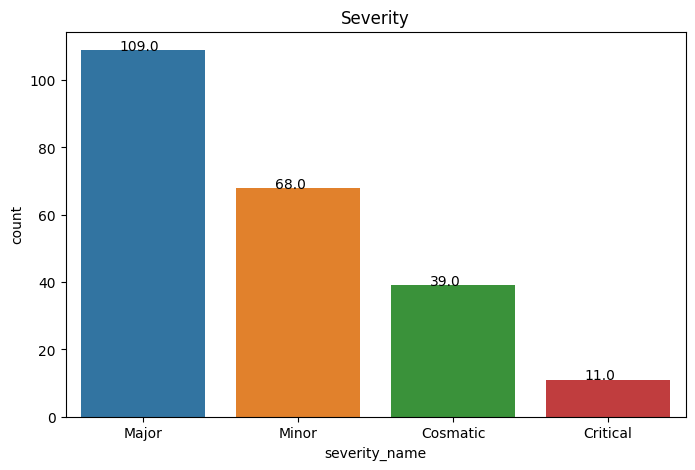

In [11]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

In [12]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

,_id,_predict_severity


# Load Model from Directory to Predict

In [13]:
if modelFile_endPoint==1 :   
    model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
    print(f"Load from {PATH_FOLDER_ARTIFACTS}")
    # model.summary()

    
    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          # print(row_dict)  

          input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}


          predictionResult = model.predict(input_dict)

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          # print(input_dict)  
            
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]


Load from model_tuned
1 - 2(Major)
1/1 [==============================] - 0s 492ms/step
[[18.870863 26.526646 35.73243  18.870056]] %   as 2
2 - 2(Major)
1/1 [==============================] - 0s 52ms/step
[[18.905897 27.017963 35.175163 18.90097 ]] %   as 2
3 - 1(Minor)
1/1 [==============================] - 0s 49ms/step
[[18.621496 20.368633 40.46821  20.541662]] %   as 2
4 - 0(Cosmatic)
1/1 [==============================] - 0s 53ms/step
[[20.941376 40.7481   19.893343 18.417183]] %   as 1
5 - 3(Critical)
1/1 [==============================] - 0s 59ms/step
[[19.321062 22.337868 27.31857  31.022495]] %   as 3
6 - 3(Critical)
1/1 [==============================] - 0s 52ms/step
[[19.322292 22.210749 27.535164 30.931795]] %   as 3
7 - 3(Critical)
1/1 [==============================] - 0s 56ms/step
[[17.69639  18.313332 46.315205 17.675064]] %   as 2
8 - 3(Critical)
1/1 [==============================] - 0s 47ms/step
[[19.32026  22.332108 27.309338 31.0383  ]] %   as 3
9 - 3(Critical)
1/

# Load Model from Online EndPpint to Predict

In [14]:
#https://console.cloud.google.com/vertex-ai/endpoints?project=pongthorn
#https://console.cloud.google.com/vertex-ai/batch-predictions?project=pongthorn

In [15]:
# instances = []
# dfX=dfNewData.drop(columns=unUsedColtoPredict)
# for index,row in dfX.iterrows():
#     dict_item=row.to_dict()
#     instance = {}
#     for key, value in dict_item.items():
#         if key in unUsedColtoPredict:
#             continue
#         if value is None:
#             value = ""
#         instance[key] = [value]
#         # instance[key] = value
#     instances.append(instance)

# print(len(instances))
# print(instances[0])

In [16]:
# Load model by refering to vertext-ai registry and create endpoint
isEndpointAvaiable=False
listRequestData=[]
try:
    ENDPOINT_ID="2704182877817405440"
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}")
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))
    
if modelFile_endPoint==2 and isEndpointAvaiable==True :

    for data in dfNewData.to_dict(orient="records"):
        incident_id=data['id']
        severity=data['severity']
        severity_name=data['severity_name']
        # convert dict to tf format
        request_data = {key : [value] for key,value in data.items() }
        for key_removed in unUsedColtoPredict:
           request_data.pop(key_removed)
        request_data = json.dumps(request_data)
        listRequestData.append(request_data)
        print(request_data)

        response = endpoint.predict([request_data])
        y_predicted = np.argmax(response.predictions, axis=1)
        predictionResult=response[0][0]
        print(predictionResult)
        print(y_predicted)

        pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
        print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
else:
     print("No endpoint to predict  as online predction")     

404 Endpoint projects/pongthorn/locations/asia-southeast1/endpoints/2704182877817405440 is not found.
No endpoint to predict  as online predction


# Classification Rerport

In [17]:
from sklearn.metrics import confusion_matrix,classification_report


In [18]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,1,2,2,Major
1,2,2,2,Major
2,3,2,1,Minor
3,4,1,0,Cosmatic
4,5,3,3,Critical
...,...,...,...,...
222,223,1,1,Minor
223,224,0,0,Cosmatic
224,225,0,0,Cosmatic
225,226,0,0,Cosmatic


In [19]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1,predcited-2,predcited-3
actual-0,31,3,5,0
actual-1,5,27,35,1
actual-2,3,12,90,4
actual-3,0,1,4,6


In [21]:

print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        39
           1       0.63      0.40      0.49        68
           2       0.67      0.83      0.74       109
           3       0.55      0.55      0.55        11

    accuracy                           0.68       227
   macro avg       0.66      0.64      0.64       227
weighted avg       0.67      0.68      0.66       227

